In [1]:
!export LC_ALL=en_US.UTF-8
!export LANG=en_US.UTF-8

In [2]:
!python -m spacy download en_core_web_md 

2023-04-19 11:32:40.382279: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 11:32:41.777496: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-19 11:32:43.112972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-19 11:32:43.113492: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returnin

In [3]:
# Run in python console
import nltk; nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy


# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
# loop through the rows of the dataframe

import pandas as pd
df= pd.read_csv("/content/drive/MyDrive/Advance machine learning/Dataset-SA.csv")
df = df.dropna()
df=df.drop("Rate",axis =1)
df= df.drop("product_name",axis =1)
df = df.drop("product_price",axis =1)
# df = df.drop("index",axis =1)
df=df.reset_index()
df



,index,Review,Summary,Sentiment
0,0,super!,great cooler excellent air flow and for this p...,positive
1,1,awesome,best budget 2 fit cooler nice cooling,positive
2,2,fair,the quality is good but the power of air is de...,positive
3,3,useless product,very bad product its a only a fan,negative
4,4,fair,ok ok product,neutral
...,...,...,...,...
180365,205047,must buy!,good product,positive
180366,205048,super!,nice,positive
180367,205049,nice,very nice and fast delivery,positive
180368,205050,just wow!,awesome product,positive


In [64]:
len(df)

180370

In [74]:
text=[]
for index, row in df.iterrows():
    # concatenate the strings in column1 and column2
    result_string = row['Review'] + ' ' + row['Summary']
    # append the result to the list
    text.append(result_string)
df_review = pd.DataFrame(text,columns=['Review'])
len(df['Sentiment'])

180370

In [75]:
len(df_review)

180370

In [81]:
len(df_review)
new_df=pd.concat([df_review['Review'],df['Sentiment']],axis= 1)
len(new_df)

180370

In [15]:
df_review.head()

,Review
0,super! great cooler excellent air flow and for...
1,awesome best budget 2 fit cooler nice cooling
2,fair the quality is good but the power of air ...
3,useless product very bad product its a only a fan
4,fair ok ok product


In [20]:
# Convert to list
data = df_review['Review'].values.tolist()


data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['super! great cooler excellent air flow and for this price its so amazing and '
 'unbelievablejust love it']


In [21]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['super', 'great', 'cooler', 'excellent', 'air', 'flow', 'and', 'for', 'this', 'price', 'its', 'so', 'amazing', 'and', 'love', 'it']]


In [22]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['super', 'great', 'cooler', 'excellent', 'air_flow', 'and', 'for', 'this', 'price', 'its', 'so', 'amazing', 'and', 'love', 'it']


In [23]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [25]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['super', 'great', 'cooler', 'excellent', 'air_flow', 'price', 'amazing', 'love']]


In [26]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [27]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('air_flow', 1),
  ('amazing', 1),
  ('cooler', 1),
  ('excellent', 1),
  ('great', 1),
  ('love', 1),
  ('price', 1),
  ('super', 1)]]

In [100]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [101]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.088*"perfect" + 0.072*"price" + 0.050*"well" + 0.048*"also" + '
  '0.047*"break" + 0.039*"go" + 0.039*"use" + 0.036*"expect" + 0.034*"job" + '
  '0.028*"time"'),
 (1,
  '0.342*"quality" + 0.063*"bad" + 0.052*"pretty" + 0.040*"get" + '
  '0.025*"little" + 0.017*"fast" + 0.016*"give" + 0.011*"make" + '
  '0.011*"experience" + 0.010*"low"'),
 (2,
  '0.182*"small" + 0.132*"size" + 0.061*"bowl" + 0.045*"specify" + '
  '0.032*"pack" + 0.028*"fair" + 0.026*"much" + 0.022*"design" + 0.021*"table" '
  '+ 0.019*"deliver"'),
 (3,
  '0.255*"awesome" + 0.195*"worth" + 0.118*"super" + 0.096*"penny" + '
  '0.094*"simply" + 0.089*"market" + 0.069*"choice" + 0.016*"osm" + '
  '0.003*"supper" + 0.003*"cute"'),
 (4,
  '0.148*"excellent" + 0.115*"great" + 0.109*"flipkart" + 0.101*"really" + '
  '0.092*"thank" + 0.066*"delivery" + 0.056*"look" + 0.043*"packing" + '
  '0.043*"packaging" + 0.019*"work"'),
 (5,
  '0.214*"money" + 0.185*"plate" + 0.106*"value" + 0.094*"love" + '
  '0.061*"amazing" + 

In [102]:
matrix = []
dict_ = gensim.corpora.Dictionary(data_lemmatized)
for i in data_lemmatized:
  matrix.append(dict_.doc2bow(i))

x = lda_model[matrix]

In [103]:
prob_list = []

for i in x:
  temp = []
  for b in i:
    temp.append(b)
  prob_list.append(temp)

In [104]:
print(len(prob_list))
print(len(new_df))

180370
180370


In [105]:
# topics_list = []
# for i in prob_list:
#   topics_list.append(np.argmax(i))

# new_df['topic'] = topics_list

topics_list = []
for i in prob_list:
  max_prob_index = np.argmax([prob[1] for prob in i[0]])
  topics_list.append(max_prob_index)

new_df['topic'] = topics_list

In [109]:
m=new_df.groupby("topic")["Sentiment"].value_counts(0)/new_df.groupby("topic")["Sentiment"].agg("count")
m

topic  Sentiment
0      positive     0.714286
       negative     0.255615
       neutral      0.030099
1      negative     0.488812
       positive     0.474699
       neutral      0.036489
2      positive     0.632699
       negative     0.297872
       neutral      0.069429
3      positive     0.916667
       negative     0.055556
       neutral      0.027778
4      positive     0.926431
       negative     0.046322
       neutral      0.027248
5      positive     0.812500
       neutral      0.125000
       negative     0.062500
6      positive     0.685714
       negative     0.285714
       neutral      0.028571
7      positive     1.000000
8      positive     0.825694
       negative     0.125282
       neutral      0.049024
Name: Sentiment, dtype: float64

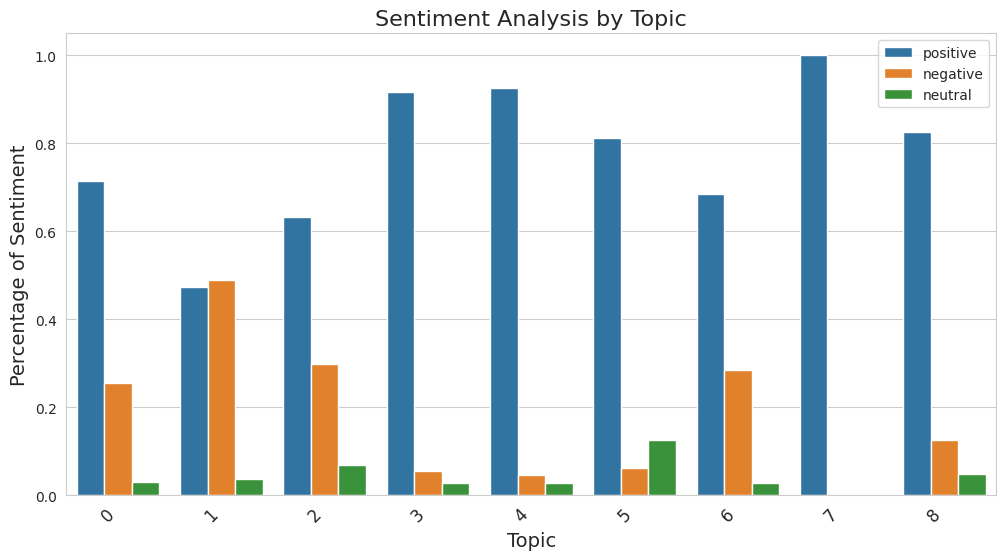

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x=m.index.get_level_values(0), y=m.values, hue=m.index.get_level_values(1))
plt.title('Sentiment Analysis by Topic', fontsize=16)
plt.xlabel('Topic', fontsize=14)
plt.ylabel('Percentage of Sentiment', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.legend(loc='upper right')
plt.show()

